In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.stats import invgamma
from geopy.distance import geodesic
from dms_variants.ispline import Isplines, Isplines_total
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
import pymc as pm
import sys

# Add the module path to sys.path
sys.path.append('../../')

# Import the model_1_pymc function
from models import model_1_pymc 

In [2]:
#----------------------------------------------------------------
# load in and parse data
#----------------------------------------------------------------

dat_all = pd.read_csv("../../data/sa_family_data.csv").sample(n=20,random_state=1)

# Parse data into location, environmental variables, and species cover/presence
location_mat = dat_all[['latitude', 'longitude']].values
env_var_names = ['gmap', 'RFL_CONC', 'Elevation30m', 'HeatLoadIndex30m', 'tmean13c', 'SoilConductivitymSm', 'SoilTotalNPercent']
envr_use = dat_all[['gmap', 'RFL_CONC', 'Elevation30m', 'HeatLoadIndex30m', 'tmean13c', 'SoilConductivitymSm', 'SoilTotalNPercent']].values
species_mat = dat_all.iloc[:, 12:].values

# Get the number of sites
ns = location_mat.shape[0]

#----------------------------------------------------------------
# Calculate Bray-Curtis dissimilarity -- see proportion of 0's and 1's
#----------------------------------------------------------------

# Define dissimilarity metric
diss_met = 'braycurtis'

# Create pair-wise response matrix. pdist outputs a 1D matrix
Z = pdist(species_mat, diss_met)

# Find indices for observations with dissimilarity of exactly 1
Z_is_one = np.where(Z == 1)[0]
Z_is_not_one = np.where(Z != 1)[0]

# Get counts
n1 = len(Z_is_one)
N = len(Z)

# Print the proportion of zeros and ones in the dissimilarity matrix
print(f"Proportion of zeros: {np.mean(Z == 0)}")
print(f"Proportion of ones: {np.mean(Z == 1)}")

#----------------------------------------------------------------
# Define covariates that will be warped by I-spline function AND coefficients
#----------------------------------------------------------------

# Calculate pairwise geographical distance in km using geodesic with WGS84 in vector form (upper triangle of matrix)
vec_distance = pdist(location_mat, lambda lat, lon: geodesic(lat, lon).kilometers)

# Define a (sub)set of environmental variables to be used as covariates
X = envr_use[:, [0, 1, 2, 3, 4, 5, 6]]

# How many knots do you want? What is the degree of the spline?
# Remember that in the specification, of the iSpline that the degree is
# one higher that what you say. Integration of m-spline adds one degree.
# Define the degree and number of knots for the I-spline basis
deg = 3
knots = 2
order = deg + 1
df = deg * knots

# Create ISpline bases, with different range (i.e. mesh) for each variable. Note NO extrapolation with this method, only interpolation.
I_spline_bases = np.column_stack([Isplines(order, [X[:,i].min(), X[:,i].min() + (X[:,i].max() - X[:,i].min())/3, X[:,i].min() + (X[:,i].max() - X[:,i].min())*2/3, X[:,i].max()], X[:,i]).I(j) for i in range(X.shape[1]) for j in range(1,df)])

# Pairwise differences of each basis function in a vector. Shape ns**2 / 2 x p * df
I_spline_bases_diffs = np.array([pdist(I_spline_bases[:, i].reshape(-1, 1), metric='euclidean') for i in range(I_spline_bases.shape[1])]).T

# Create spline for the geodesic distances
dist_mesh = [vec_distance.min(), vec_distance.min() + (vec_distance.max() - vec_distance.min())/3, vec_distance.min() + (vec_distance.max() - vec_distance.min())*2/3, vec_distance.max()]
dist_splines = np.column_stack([Isplines(order, dist_mesh, vec_distance).I(i) for i in range(1, df)])

# Combine the I-spline bases and the geographical distances
X_GDM = np.column_stack([I_spline_bases_diffs, dist_splines])

# Name columns
column_names = [f"{var}_I{j}" for var in env_var_names for j in range(1, df)] + [f"Dist_I{j}" for j in range(1, df)]
X_GDM_df = pd.DataFrame(X_GDM, columns=column_names)
p = X_GDM.shape[1]

# Get row and column indices for each dissimilarity 
row_ind, col_ind = np.triu_indices(ns, k=1)

#------------------------------------------------------------------------
# Get initial values to speed up spGDMM fitting
#------------------------------------------------------------------------

# Fit linear model
lm_mod = LinearRegression(fit_intercept=True).fit(X_GDM, np.log(Z))

# Define objective function
objective = lambda params: np.sum((np.log(Z) - params[0] - X_GDM @ np.exp(params[1:(p+1)]))**2)

# Set up initial parameters, taking logs of positive and setting negative coefficients to -10
initial_params = np.concatenate([
    [0.3],  # Intercept, why chosen to be this?
    np.where(lm_mod.coef_ > 0, np.log(lm_mod.coef_), -10),  # Log coefficients greater than 0, and set those < 0 to -10
    #np.random.randn(ns)  # Random values for each site
])

optimized_params = minimize(objective, initial_params, method='BFGS').x

#------------------------------------------------------------------------
# Fix spatial range parameter (rho = 1 / phi) heuristically (can also estimate using the data, or even deep GP). 
# Setting up spatial correlation structure.
#------------------------------------------------------------------------

rho_fix = np.max(vec_distance) / 10
R_spat_mat = squareform(np.exp(- vec_distance / rho_fix))
#chol_R = np.linalg.cholesky(R_spat_mat).T
R_inv = np.linalg.inv(R_spat_mat)

#------------------------------------------------------------------------
# Define design matrix for a polynomial log-variance
#------------------------------------------------------------------------

# NOTE these features are not orthogonal as they were in the R implementation
X_sigma = PolynomialFeatures(degree=3, include_bias=True).fit_transform(vec_distance.reshape(-1, 1))
p_sigma = X_sigma.shape[1]


Proportion of zeros: 0.0
Proportion of ones: 0.08947368421052632


/tmp/ipykernel_357066/501244899.py:91: RuntimeWarning: invalid value encountered in log
  np.where(lm_mod.coef_ > 0, np.log(lm_mod.coef_), -10),  # Log coefficients greater than 0, and set those < 0 to -10


In [3]:

#------------------------------------------------------------------------
# Source nimble models -- Models 1-9 match those in paper
#------------------------------------------------------------------------

# Create constants for the model
constants = {
    'n': N,
    'p': p,
    'x': X_GDM,
    'n_loc': ns,
    'p_sigma': p_sigma,
    'X_sigma': X_sigma,
    'R_inv': R_inv,
    'zeros': np.zeros(ns),
    'row_ind': row_ind,
    'col_ind': col_ind
}

# Create data for the model
data = {
    'log_V': np.where(Z == 1, np.nan, np.log(Z)),
    'censored': (Z == 1).astype(int),
    'c': np.zeros(constants['n'])
}

# Create initial values for the model
inits = {
    'beta_0': optimized_params[0],
    'log_beta': optimized_params[1:(p+1)],
    'sig2_psi': 1,
    'beta_sigma': np.array([-5, -20, 12, 2]),
    'psi': optimized_params[(p+1):]
}

with pm.Model() as model:
        # Define the priors
        beta_0 = pm.Normal('beta_0', mu=0, sigma=10)
        beta = pm.Lognormal('beta', mu=0, sigma=10, shape=p)

        # Calculate the linear predictor
        linpred = pm.math.dot(X_GDM[:,1:p+1], beta)
        
        # Define the likelihood
        sigma2 = pm.InverseGamma('sigma2', alpha=1, beta=1)
        mu = beta_0 + linpred
        log_V_obs = pm.Normal('log_V_obs', mu=mu, sigma=pm.math.sqrt(sigma2), observed=log_V)
        
        # Sample from the posterior with progress bar enabled
        trace = pm.sample(1000, return_inferencedata=True, progressbar=True)


NameError: name 'log_V' is not defined

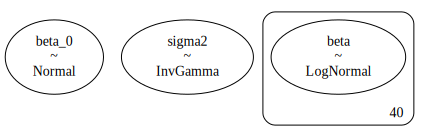

In [4]:
model.to_graphviz()

In [14]:
import pymc as pm

# Check if pm.math is available
print(dir(pm.math))

# Example usage of pm.math.dot
import numpy as np

X = np.random.randn(100, 5)
beta = np.random.randn(5)

linpred = pm.math.dot(X, beta)
print(linpred)

['Apply', 'BatchedDiag', 'LogDet', 'Op', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'abs', 'and_', 'arccos', 'arccosh', 'arcsin', 'arcsinh', 'arctan', 'arctanh', 'batched_diag', 'block_diagonal', 'broadcast_to', 'cartesian', 'ceil', 'clip', 'concatenate', 'constant', 'cos', 'cosh', 'cumprod', 'cumsum', 'dot', 'eq', 'erf', 'erfc', 'erfcinv', 'erfinv', 'exp', 'expand_packed_triangular', 'flat_outer', 'flatten', 'flatten_list', 'floatX', 'floor', 'full', 'full_like', 'ge', 'gt', 'invlogit', 'invprobit', 'kron_diag', 'kron_dot', 'kron_matrix_op', 'kron_solve_lower', 'kron_solve_upper', 'kronecker', 'le', 'log', 'log1mexp', 'log1mexp_numpy', 'log1pexp', 'log_softmax', 'logaddexp', 'logbern', 'logdet', 'logdiffexp', 'logdiffexp_numpy', 'logit', 'logsumexp', 'lt', 'matmul', 'matrix_inverse', 'max', 'maximum', 'mean', 'min', 'minimum', 'neq', 'np', 'ones', 'ones_like', 'or_', 'partial', 'probit', 'prod', 'pt', 'pytensor'

In [13]:
import pymc as pm
print(pm.__version__)
from pymc import math

5.16.2
